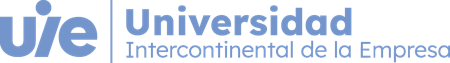

**G24GXX3.10X. Aprendizaje Automático**

**Profesor: Borja González Seoane**

Curso 2024-25

# PL06. Clusterización con DBSCAN

En esta práctica se implementará y probará una versión _from scratch_ del algoritmo de clusterización DBSCAN. Se usarán datos generados sintéticamente para comprobar el funcionamiento del algoritmo, aprovechando para probar previamente el uso de *KMeans* sobre esos mismos datos, a modo de comparación. **Este _notebook_ servirá también para desglosar el algoritmo DBSCAN, visto en las transparencias de clase, utilizando celdas Markdown y comentarios para ir componiendo un guión y un pseudocódigo paso a paso.**


## Clusterización con DBSCAN

<!-- Texto en rojo -->
<font color='red'>
#TODO: Añada aquí una descripción del algoritmo DBSCAN utilizando sus propias palabras...
</font>


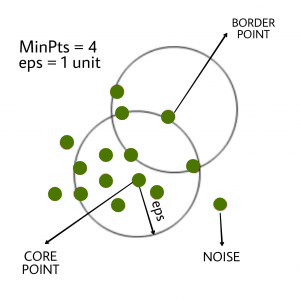

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

## Creación de círculos concéntricos con puntos de ruido

Impleméntese una función auxiliar que genere una circunferencia de puntos de ruido. Parametrícese con `n` y `r` para el número de puntos y el radio de la circunferencia, respectivamente. Se usará esta función para la generación de datos sintéticos con los que confrontar *K-means* y DBSCAN.

In [94]:
def puntos_en_circunferencias(n: int, r: int) -> np.ndarray:
    """
    Genera `n` puntos en una circunferencia de radio `r` con ruido gaussiano.
    
    Args:
        n: Número de puntos a generar
        r: Radio de la circunferencia
    
    Returns:
        Array numpy de forma (n,2) con las coordenadas de los puntos
    """
    # Generar ángulos equidistantes
    angulos = np.linspace(0, 2*np.pi, n)
    
    # Calcular coordenadas x,y
    x = r * np.cos(angulos)
    y = r * np.sin(angulos)
    
    # Añadir ruido gaussiano
    ruido = np.random.normal(0, 0.1, (n,2))
    
    # Combinar coordenadas y ruido
    puntos = np.column_stack((x,y)) + ruido
    
    return puntos


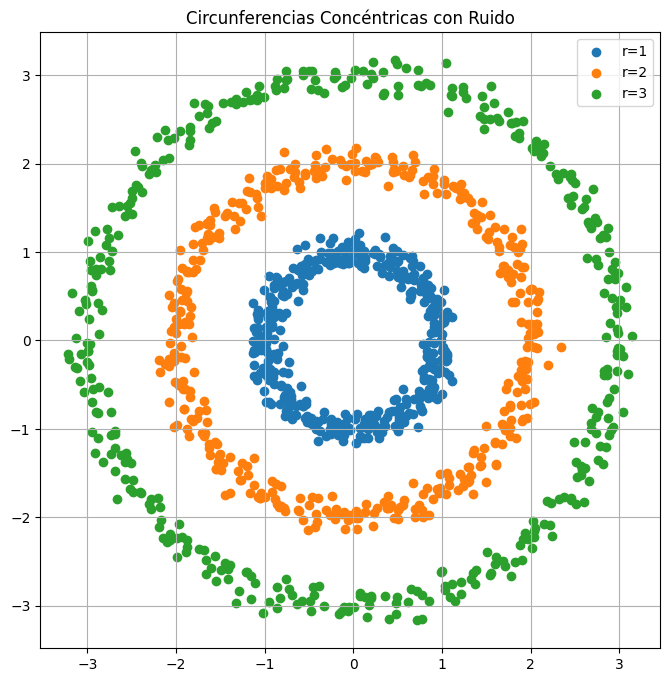

In [95]:
# Crea 3 circunferencias concéntricas
n_puntos = 400
radio1, radio2, radio3 = 1, 2, 3

puntos1 = puntos_en_circunferencias(n_puntos, radio1)
puntos2 = puntos_en_circunferencias(n_puntos, radio2)
puntos3 = puntos_en_circunferencias(n_puntos, radio3)

# Visualizar los resultados
plt.figure(figsize=(8, 8))
plt.scatter(puntos1[:, 0], puntos1[:, 1], label='r=1')
plt.scatter(puntos2[:, 0], puntos2[:, 1], label='r=2')
plt.scatter(puntos3[:, 0], puntos3[:, 1], label='r=3')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.title('Circunferencias Concéntricas con Ruido')
plt.show()

## Úsese *K-means* _scratch_ o Scikit-Learn para intentar clusterizar los datos generados

¿Qué ocurre? ¿Resulta útil *K-means* para este tipo de datos?

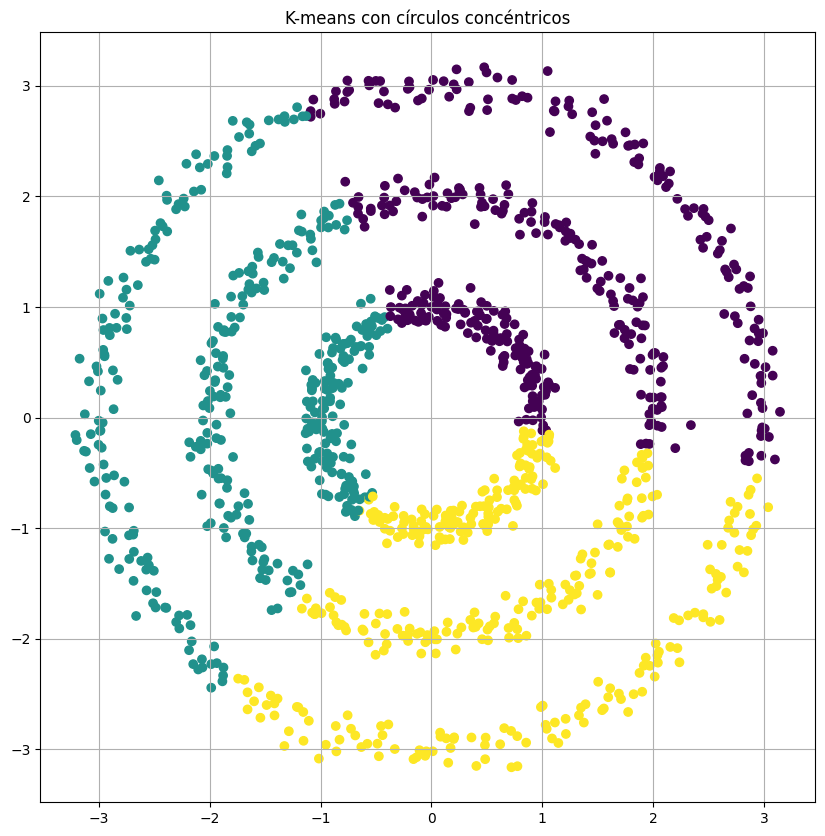

In [96]:
# Usar kmeans sobre los datos y ver la segmentación


K = 3

# Crear instancia de K-Means con N clusteres
kmeans = KMeans(n_clusters=K, random_state=42)

# Combinar todos los puntos
X = np.vstack((puntos1, puntos2, puntos3))

# Entrenar el modelo con los datos de los circulos concentricos
kmeans.fit(X)

# Obtener las predicciones
y_pred = kmeans.predict(X)

# Visualizar los resultados
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='viridis')

plt.title('K-means con círculos concéntricos')

plt.grid(True)
plt.show()


## Prueba inicial con DBSCAN de Scikit-Learn

Para saber a qué atenerse a la hora de implementar DBSCAN _scratch_.

array([0, 1, 2], dtype=int64)

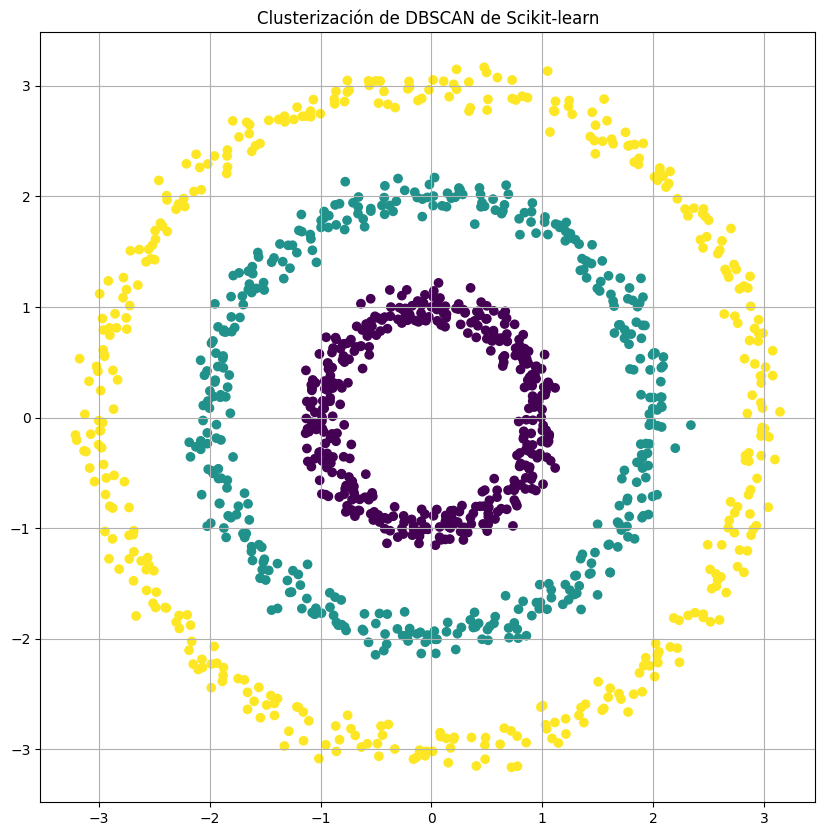

In [97]:
# Entrenar la instancia de DBSCAN

dbscan_nk = DBSCAN()

dbscan_nk.fit(X)


# Visualizar cúantos clústeres se han encontraod

cluster_labels_sk = dbscan_nk.labels_
display(np.unique(cluster_labels_sk))

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_sk, cmap='viridis')

plt.title('Clusterización de DBSCAN de Scikit-learn')

plt.grid(True)
plt.show()

## DBSCAN _scratch_ paso a paso

Úsese la clase arquetipo habitual en las sesiones de laboratorio para implementar DBSCAN.

### Arquetipo

```python
class DBSCANScratch:
    def __init__(self):  # Constructor de la clase. Impleméntese si es necesario
        pass

    def fit(self, X: np.ndarray):
        raise NotImplementedError("Impleméntese este arquetipo esqueleto")

    def predict(self, X: np.ndarray) -> np.ndarray:
        raise NotImplementedError("Impleméntese este arquetipo esqueleto")
```

### Pseudocódigo

<!-- Texto en rojo -->
<font color='red'>
#TODO: Añada aquí una relación paso a paso del algoritmo DBSCAN, como si de un pseudocódigo se tratara...
</font>

In [98]:
class DBSCANScratch:
    def __init__(self, eps=0.3, min_samples=10):
        self.eps = eps
        self.min_samples = min_samples
        self._labels = None

    def _encontrar_vecinos(self, X: np.ndarray, idx_punto: int) -> np.ndarray:
        """Encuentra los vecinos dentro del radio eps"""
        distancias = np.linalg.norm(X - X[idx_punto], axis=1)
        return np.where(distancias <= self.eps)[0]

    def fit(self, X: np.ndarray):
        """Ajusta el modelo DBSCAN a los datos"""
        n_muestras = X.shape[0]
        self._labels = np.zeros(n_muestras)  # 0: no visitado, -1: ruido, >0: cluster ID
        
        cluster_id = 1
        for idx_punto in range(n_muestras):
            # Si el punto ya ha sido visitado, pasa al siguiente
            if self._labels[idx_punto] != 0:  # Corregido aquí
                continue
            
            # Encuentra los vecinos del punto actual
            vecinos = self._encontrar_vecinos(X, idx_punto)
            
            # Si no hay suficientes vecinos, marca como ruido
            if len(vecinos) < self.min_samples:
                self._labels[idx_punto] = -1
                continue
            
            # Expandir el cluster actual
            self._labels[idx_punto] = cluster_id
            i = 0
            while i < len(vecinos):
                vecino = vecinos[i]
                
                if self._labels[vecino] == -1:
                    self._labels[vecino] = cluster_id
                
                elif self._labels[vecino] == 0:
                    self._labels[vecino] = cluster_id
                    nuevos_vecinos = self._encontrar_vecinos(X, vecino)
                    
                    if len(nuevos_vecinos) >= self.min_samples:
                        vecinos = np.concatenate([vecinos, nuevos_vecinos])
                
                i += 1
            
            cluster_id += 1
        
        return self



## Prueba de la implementación de DBSCAN

array([-1.,  1.,  2.,  3.,  4.])

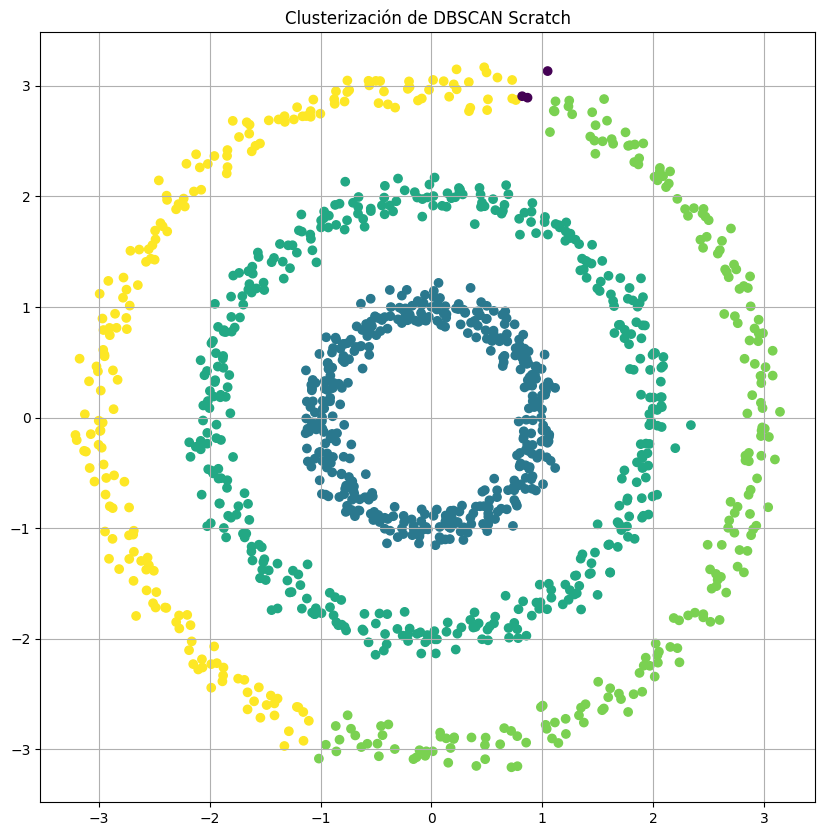

In [99]:
# Probar el algoritmo corregido
dbscan_scratch = DBSCANScratch(eps=0.3, min_samples=10)
dbscan_scratch.fit(X)

cluster_labels_scratch = dbscan_scratch._labels
display(np.unique(cluster_labels_scratch))

plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=cluster_labels_scratch, cmap='viridis')
plt.title('Clusterización de DBSCAN Scratch')
plt.grid(True)
plt.show()